# Uvod #

U svijetu dubokog učenja postoji više od pukih gustih slojeva. Postoje deseci vrsta slojeva koje možete dodati modelu. (Probajte pregledavati [Keras docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/) za uzorak!) Neki su poput gustih slojeva i definiraju veze između neurona, a drugi mogu raditi pretprocesiranje ili transformacije drugih vrsta.

U ovoj lekciji naučit ćemo o dvije vrste posebnih slojeva koji sami ne sadrže neurone, ali dodaju neke funkcije koje ponekad mogu koristiti modelu na razne načine. Oba se obično koriste u modernim arhitekturama.

# Dropout #

Prvi od njih je "ispadajući sloj", koji može pomoći u ispravljanju prekomjernog postavljanja.

U prošloj vježbi govorili smo o tome kako je overfitting uzrokovan mrežom koja uči lažne obrasce u podacima o obuci. Da bi prepoznali ovi lažni obrasci, mreža će se često oslanjati na vrlo specifične kombinacije težine, svojevrsnu "zavjeru" težina. Budući da su tako specifični, obično su krhki: uklonite jedan i zavjera se raspada.

Ovo je ideja iza **dropouta**. Kako bismo razbili ove zavjere, nasumično *ispuštamo* dio ulaznih jedinica sloja u svakom koraku obuke, što mreži otežava učenje tih lažnih obrazaca u podacima obuke. Umjesto toga, mora tražiti široke, općenite obrasce, čiji su obrasci težine obično robusniji.

<figure style="padding: 1em;">
<img src="figs/a86utxY.gif" width="600" alt="An animation of a network cycling through various random dropout configurations.">
<figcaption style="textalign: center; font-style: italic"><center>Ovdje je 50% ispadanja dodano između dva skrivena sloja.</center></figcaption>
</figure>

O ispadanju možete razmišljati i kao o stvaranju neke vrste *ansambla* mreža. Predviđanja više neće raditi jedna velika mreža, već odbor manjih mreža. Pojedinci u odboru skloni su činiti različite vrste grešaka, ali su u isto vrijeme u pravu, čineći odbor u cjelini boljim od bilo kojeg pojedinca. (Ako ste upoznati s random forest kao skupom stabala odlučivanja, to je ista ideja.)

## Dodavanje dropout-a ##

U Kerasu, argument stope ispadanja `rate` definira koji postotak ulaznih jedinica treba isključiti. Stavite sloj `Dropout` neposredno prije sloja na koji želite primijeniti ispadanje:

```
keras.Sequential([
    # ...
    layers.Dropout(rate=0.3), # apply 30% dropout to the next layer
    layers.Dense(16),
    # ...
])
```

# Batch normalization #

Sljedeći posebni sloj koji ćemo pogledati izvodi "normalizaciju serije" (ili "batchnorm"), što može pomoći u ispravljanju treninga koji je spor ili nestabilan.

S neuronskim mrežama općenito je dobra ideja staviti sve svoje podatke na zajedničku ljestvicu, možda s nečim poput [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) ili [MinMaxScalera](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) scikit-learn-a. Razlog je taj što će SGD pomaknuti mrežne težine proporcionalno veličini aktivacije koju podaci proizvode. Značajke koje proizvode aktivacije vrlo različitih veličina mogu uzrokovati nestabilno ponašanje pri vježbanju.

Sada, ako je dobro normalizirati podatke prije nego što odu u mrežu, možda bi i normalizacija unutar mreže bila bolja! Zapravo, imamo posebnu vrstu sloja koji to može učiniti, **sloj normalizacije serije**. Sloj normalizacije serije promatra svaku seriju kako dolazi, prvo normalizirajući seriju s vlastitom srednjom vrijednosti i standardnom devijacijom, a zatim također stavljajući podatke na novu ljestvicu s dva parametra skaliranja koja se mogu obučiti. Batchnorm, zapravo, izvodi neku vrstu koordiniranog skaliranja svojih ulaza.

Najčešće se batchnorm dodaje kao pomoć u procesu optimizacije (iako ponekad može pomoći i pri predviđanju izvedbe). Modeli s batchnormom obično trebaju manje epoha za dovršenje obuke. Štoviše, batchnorm također može popraviti razne probleme koji mogu uzrokovati "zaglavljivanje" obuke. Razmislite o dodavanju skupne normalizacije svojim modelima, posebno ako imate problema tijekom obuke.

## Dodavanje batch normalizacije ##

Čini se da se skupna normalizacija može koristiti u gotovo bilo kojoj točki mreže. Možete ga staviti nakon sloja...

```
layers.Dense(16, activation='relu'),
layers.BatchNormalization(),
```

... ili između sloja i njegove funkcije aktivacije:

```
layers.Dense(16),
layers.BatchNormalization(),
layers.Activation('relu'),
```

A ako ga dodate kao prvi sloj vaše mreže, on može djelovati kao vrsta adaptivnog pretprocesora, zamjenjujući nešto poput `StandardScalera` Sci-Kit Learna.

# Primjer - Korištenje dropouta i skupne normalizacije #

Nastavimo razvijati model *Red Wine*. Sada ćemo još više povećati kapacitet, ali dodati ispadanje za kontrolu prekomjernog opremanja i normalizaciju serije kako bismo ubrzali optimizaciju. Ovaj put ćemo također izostaviti standardizaciju podataka kako bismo pokazali kako serijska normalizacija može stabilizirati obuku.

In [1]:

# Setup plotting
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)


import pandas as pd
red_wine = pd.read_csv('./input/red-wine.csv')

# Create training and validation splits
df_train = red_wine.sample(frac=0.7, random_state=0)
df_valid = red_wine.drop(df_train.index)

# Split features and target
X_train = df_train.drop('quality', axis=1)
X_valid = df_valid.drop('quality', axis=1)
y_train = df_train['quality']
y_valid = df_valid['quality']

Prilikom dodavanja dropout-a, možda ćete morati povećati broj jedinica u vašim `Dense` slojevima.

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(1024, activation='relu', input_shape=[11]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1),
])

c:\Users\A507\bonic_paula\Lab3_online\labs\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Ovaj put ne trebamo ništa promijeniti u načinu na koji smo postavili trening.

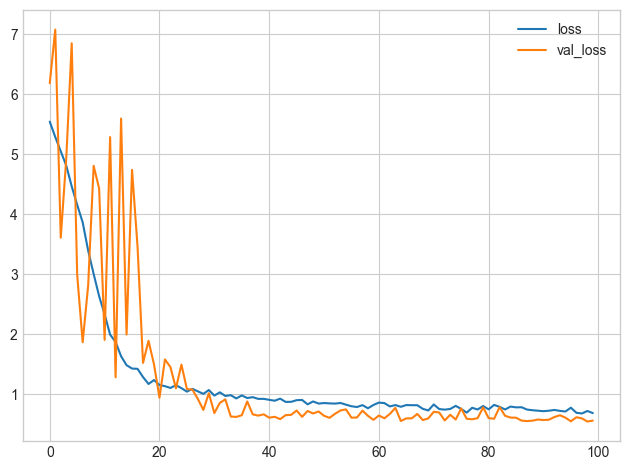

In [3]:
model.compile(
    optimizer='adam',
    loss='mae',
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=100,
    verbose=0,
)


# Show the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

Obično ćete postići bolje performanse ako standardizirate svoje podatke prije upotrebe za učenje. Međutim, činjenica da smo uopće mogli upotrijebiti neobrađene podatke pokazuje koliko učinkovita može biti skupna normalizacija na težim skupovima podataka.

# Zadatak #

Prijeđite na [**sljedeći zadatak**](Dropout_and_Batch_Normalization_exercise_hr.ipynb) na *Spotify* skupu podataka s dropoutom i pogledajte kako skupna normalizacija može pomoći s teškim skupovima podataka.